In [1]:
from tqdm import tqdm
import scipy
import rdata
from sklearn.model_selection import train_test_split
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from optax import adam, chain, clip

from numpyro import distributions as dist

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg

import math
import torch
import gpytorch




numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()


In [2]:
# UCI regression datasets with less than 1000 observations

from uci_datasets import all_datasets
[name for name, (n_observations, n_dimensions) in all_datasets.items() if n_observations < 1000]

['autompg',
 'challenger',
 'concreteslump',
 'energy',
 'forest',
 'stock',
 'yacht',
 'autos',
 'breastcancer',
 'fertility',
 'housing',
 'machine',
 'pendulum',
 'servo']

In [3]:
from uci_datasets import Dataset
# data = Dataset('yacht')
# data = Dataset('stock')
data = Dataset('concrete')
# data = Dataset('parkinsons')
# data = Dataset('elevators')
# data = Dataset("airfoil")

X_train, y_train, X_test, y_test = data.get_split(split=5)  # there are 10 different trainning-test splits

y_train = y_train.squeeze(); y_test = y_test.squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

concrete dataset, N=1030, d=8


((927, 8), (103, 8), (927,), (103,))

In [4]:
# Normalize data 
X_train_max = X_train.max(0)
X_train_min = X_train.min(0)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train = (y_train - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std



In [5]:
%%script true
print(model.covar_module.base_kernel.lengthscale.detach().numpy())
print(model.covar_module.outputscale.detach().numpy())
print(model.likelihood.noise_covar.noise.detach().numpy())
print(model.mean_module.constant.item())

In [6]:
def train_and_predict_single_gp(X_train,y_train,X_test,X_val,kappa,lambdaa):
    Xtrain_torch = torch.from_numpy(X_train).type(torch.float32)
    Ytrain_torch = torch.from_numpy(y_train).type(torch.float32).squeeze(-1)
    Xtest_torch = torch.from_numpy(X_test).type(torch.float32)
    Xval_torch = torch.from_numpy(X_val).type(torch.float32)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            lengthscale_prior = gpytorch.priors.GammaPrior(1, 1)
            outputscale_prior = gpytorch.priors.GammaPrior(1, 2)

            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
                ard_num_dims=Xtrain_torch.shape[1],
                lengthscale_prior = lengthscale_prior
                )
                ,outputscale_prior = outputscale_prior,
                )
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.GammaPrior(1, 1))
    model_gpy = ExactGPModel(Xtrain_torch, Ytrain_torch, likelihood)

    # hypers = {
    #     'likelihood.noise_covar.noise': torch.tensor(0.5),
    #     'covar_module.base_kernel.lengthscale': torch.tensor(0.5)*torch.ones(X_train.shape[1],1),
    #     'covar_module.outputscale': torch.tensor(1.0),
    # }

    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(1.0*y_train.var()/kappa**2),
        'covar_module.base_kernel.lengthscale': torch.from_numpy(np.std(X_train,axis=0)/lambdaa),
        'covar_module.outputscale': torch.tensor(1.0*y_train.var()),
        'mean_module.constant': torch.tensor(y_train.mean())
    }


    model_gpy.initialize(**hypers);

    # print(model_gpy.mean_module.constant.item())

    training_iter = 100

    model_gpy.train()
    likelihood.train()   

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model_gpy.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs: - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gpy)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model_gpy(Xtrain_torch)  # this is for computing the prior GP model
        # Calc loss and backprop gradients
        loss = -mll(output, Ytrain_torch)
        loss.backward()
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model_gpy.eval()
    likelihood.eval()

    # print(model_gpy.mean_module.constant.item())

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_preds = likelihood(model_gpy(Xtest_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()
        train_preds = likelihood(model_gpy(Xtrain_torch)); # prediccion de las ytrain (no ftrain) ya que estamos usando likelihood()
        val_preds = likelihood(model_gpy(Xval_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()


    return test_preds, train_preds, val_preds
   

In [7]:
def split_dataset(X, Y, n_splits, split_size, with_replacement=True):
    np.random.seed(0)
    n_samples = X.shape[0]
    # split_size = n_samples // n_splits

    if with_replacement:
        splits = [(X[indices], Y[indices]) for indices in [np.random.choice(n_samples, split_size, replace=True) for _ in range(n_splits)]]
    else:
        if split_size * n_splits > n_samples:
            raise ValueError("Cannot split without replacement as there are not enough samples.")
        indices = np.random.permutation(n_samples)
        splits = [(X[indices[i * split_size:(i + 1) * split_size]], Y[indices[i * split_size:(i + 1) * split_size]]) for i in range(n_splits)]
    
    
    return splits


In [8]:
X_train.shape

(927, 8)

# Create validation set and experts' predictions

In [9]:
import numpy as np

def create_validation_set(splits, n_points_per_split):
    np.random.seed(0)
    X_val = []
    y_val = []
    
    # Iterate over each split
    for X_split, y_split in splits:
        
        # Randomly select n_points_per_split indices from the split
        selected_indices = np.random.choice(len(X_split), n_points_per_split, replace=False)
        
        # Add the selected points to the validation set
        X_val.append(X_split[selected_indices])
        y_val.append(y_split[selected_indices])
        
        # Optional: Remove the selected points from the original split (if desired)
        # X_split = np.delete(X_split, selected_indices, axis=0)
        # y_split = np.delete(y_split, selected_indices, axis=0)
        
    # Combine the validation points from all splits
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    
    return X_val, y_val

n_experts = 5
n_data_per_expert = X_train.shape[0]//n_experts

splits = split_dataset(X_train, y_train, 
                       n_splits=n_experts, 
                       split_size=n_data_per_expert, 
                      #  split_size = 100,
                      #  with_replacement=True,  
                      with_replacement=False,    # partition
                       )

n_points_per_split = 10
X_val, y_val = create_validation_set(splits, n_points_per_split)

In [10]:

mu_preds_val = np.zeros((X_val.shape[0],len(splits)))
std_preds_val = np.zeros((X_val.shape[0],len(splits)))

mu_preds_test = np.zeros((X_test.shape[0],len(splits)))
std_preds_test = np.zeros((X_test.shape[0],len(splits)))

kappa = 2   # in [2,100]
lambdaa = 2  # in [1,10]
# cmap = matplotlib.colormaps['viridis']
for i, (X_split, y_split) in enumerate(splits):
   test_preds, _, val_preds = train_and_predict_single_gp(X_train=X_split,
                                y_train=y_split,
                                X_test=X_test,
                                X_val = X_val,
                                kappa=kappa,
                                lambdaa = lambdaa)
   
   mu_preds_val[:,i] = val_preds.mean.numpy()
   std_preds_val[:,i] = np.sqrt(val_preds.variance.numpy())

   mu_preds_test[:,i] = test_preds.mean.numpy()
   std_preds_test[:,i] = np.sqrt(test_preds.variance.numpy())



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [11]:
# compute negative test loglikelihood for every expert before the fusion

def compute_neg_log_like(mus,stds,y_test):
    negloglik = np.zeros((y_test.shape[0],mus.shape[1]))
    for i in range(mus.shape[1]):
       negloglik[:,i] = -1.0*scipy.stats.norm.logpdf(y_test, mus[:,i],stds[:,i])

    return negloglik.mean(0)   

nlpd = compute_neg_log_like(mu_preds_test,std_preds_test,y_test)

In [12]:
nlpd

array([0.64881526, 0.60605996, 0.53782804, 0.49865531, 0.68029906])

In [13]:
test_preds, _, _ = train_and_predict_single_gp(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                X_val = X_val,
                                kappa=kappa,
                                lambdaa=lambdaa)

nlpd_single = compute_neg_log_like(test_preds.mean.numpy().reshape(-1,1),
                                   np.sqrt(test_preds.variance.numpy().reshape(-1,1)),
                                   y_test)
nlpd_single

array([0.52529259])

# gPoEs

In [14]:
# fusion of GP predictions using log-linear pooling with weights computed "at prediction time" (a la gPoEs, rBCM, etc.)

def product_fusion(mus,stds,X_test):
    prec_fused = np.zeros((X_test.shape[0],1))
    mean_fused = np.zeros((X_test.shape[0],1))
    w_gpoe = np.zeros(mus.shape)
    noise = np.var(y_train)/kappa**2   # we are using the (same for all experts) unlearned hyperparameter values
    variance = np.var(y_train)
    for n, x in enumerate(X_test):

        weights = 0.5*(np.log(noise+variance) - np.log(stds[n,:]**2))
        weights = weights / np.sum(weights)

        precs = 1/stds[n,:]**2

        prec_fused[n,:] = weights @ precs
        mean_fused[n,:] = weights @ (mus[n,:]*precs) / prec_fused[n,:]

        # store weights
        w_gpoe[n,:] = weights

    return mean_fused, 1/np.sqrt(prec_fused), w_gpoe

In [15]:
mus_gpoe, stds_gpoe, w_gpoe = product_fusion(mu_preds_test,std_preds_test,X_test)

In [16]:
nlpd_gpoe = compute_neg_log_like(mus_gpoe,
                                 stds_gpoe,
                                 y_test)
nlpd_gpoe

array([0.43094609])

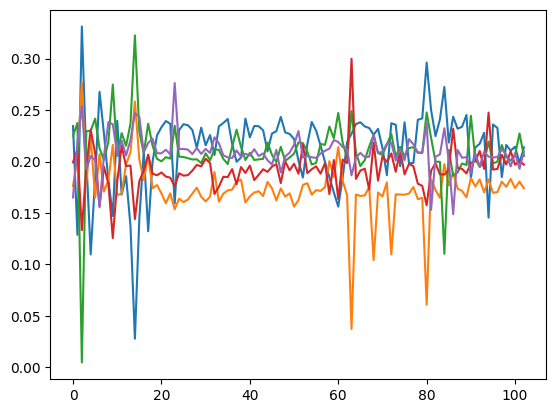

In [17]:
for i in range(w_gpoe.shape[1]):
    plt.plot(w_gpoe[:,i])

# PHS 

In [18]:
# squared euclidean distance
def sqeuclidean_distance(x, y):
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func, x, y):
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

def SE_kernel(X, Y, var, length, noise, jitter=1.0e-6, include_noise=True):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, X / length, Y / length
    )

    assert deltaXsq.shape == (X.shape[0], Y.shape[0])

    # rbf function
    K = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        K += (noise + jitter) * jnp.eye(X.shape[0])
    return K

vmap_SE_kernel = jax.vmap(SE_kernel, in_axes=(None, None, 0, 0, 0))

def predict_with_mean(
    rng_key,
    X,
    Y,
    X_test,
    var,
    length,
    noise,
    kernel_func=SE_kernel,
    mean_func=lambda x: jnp.zeros(x.shape[0]),
):
    # compute kernels between train and test data, etc.
    k_pp = kernel_func(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel_func(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel_func(X, X, var, length, noise, include_noise=True)
    K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
    K = k_pp - jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, jnp.transpose(k_pX))
    )
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = mean_func(X_test) + jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y - mean_func(X))
    )
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, jnp.sqrt(jnp.diag(K))


vmapped_pred_with_mean = jax.vmap(
    predict_with_mean, in_axes=(None, None, 0, None, 0, 0, 0, None, None)
)

vmapped_pred_with_mean = jax.vmap(
    vmapped_pred_with_mean,
    in_axes=(None, None, 1, None, 1, 1, 1, None, None),
)

def mult_stack_gp_w_model(X, mu_preds, std_preds, y_val=None):
    N, M = mu_preds.shape

    assert mu_preds.shape == std_preds.shape

    tau_preds = 1 / std_preds**2

    ######################
    # GP for log weights #
    ######################
    with numpyro.plate("M", M):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_length = numpyro.sample("kernel_length", dist.InverseGamma(5.0, 5.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))

    k = numpyro.deterministic(
        "k", vmap_SE_kernel(X, X, kernel_var, kernel_length, kernel_noise)
    )

    with numpyro.plate("logw_plate", M, dim=-1):
        log_w = numpyro.sample(
            "w_un", dist.MultivariateNormal(loc=-jnp.log(M), covariance_matrix=k)
        )

    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(log_w))

    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->n", tau_preds, w)
    )  # N,

    assert tau_fused.shape == (N,)
    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->n", tau_preds, mu_preds, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused)),
        obs=y_val,
    )

    numpyro.deterministic(
        "lpd_point",
        jax.scipy.stats.norm.logpdf(
        jnp.squeeze(y_val), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused))    
    )

In [19]:
def train_stacking(model=None):
    mcmc = MCMC(
    NUTS(model, 
         init_strategy=numpyro.infer.initialization.init_to_median,
         ),
    num_warmup=100,
    num_samples=100,
    num_chains=4,
)

    mcmc.run(random.PRNGKey(0), 
            X_val,   
            mu_preds_val, 
            std_preds_val, 
            y_val=y_val, 
            )
    mcmc.print_summary()
    samples = mcmc.get_samples()

    return samples


def predict_stacking(model,samples,prior_mean = lambda x:  jnp.zeros(x.shape[0])):

    res = vmapped_pred_with_mean(
        random.PRNGKey(0),
        X_val,
        samples["w_un"],
        X_test, # TEST DATA
        samples["kernel_var"],
        samples["kernel_length"],
        samples["kernel_noise"],
        SE_kernel,
        prior_mean,
    )


    # w_un_samples = jnp.asarray(res[0] + np.random.randn(*res[0].shape) * res[1])
    w_un_samples = jnp.asarray(res[0])
    pred_samples = {"w_un": jnp.transpose(w_un_samples, (1, 0, 2))}

    predictive = Predictive(model, pred_samples)
    pred_samples = predictive(
        random.PRNGKey(0),
        X=X_test, # TEST DATA
        mu_preds=mu_preds_test,  # TEST DATA
        std_preds=std_preds_test, # TEST DATA
        y_val = y_test, # TEST DATA
    )

    lpd_test = jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0])

    return pred_samples, lpd_test



def get_ysamples(mus,stds,w):
    def sample_mixture_gaussian(n_samples, means, std_devs, weights):    
        n_components = len(means)
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1") # Check that weights sum to 1
        
        if len(std_devs) != n_components:
            raise ValueError("The number of means and standard deviations must be the same")
        
        # Sample from a uniform distribution to decide which Gaussian to sample from
        mixture_component = np.random.choice(n_components, size=n_samples, p=weights)
        
        # Allocate array for samples
        samples = np.zeros(n_samples)
        
        # Sample from each Gaussian based on the mixture component
        for i in range(n_components):
            component_samples = np.random.normal(loc=means[i], scale=std_devs[i], size=np.sum(mixture_component == i))
            samples[mixture_component == i] = component_samples
        
        return samples
        
    n_samples = 1000
    ysamples = np.zeros((X_test.shape[0],n_samples))
    for i in range(X_test.shape[0]):
        means = mus[i,:]  # Means of the two Gaussians
        std_devs = stds[i,:]  # Standard deviations of the two Gaussians
        weights = w[i,:]  # Weights for the two Gaussians (must sum to 1)

        ysamples[i,:] = sample_mixture_gaussian(n_samples, means, std_devs, weights)

    return ysamples


def plot_stacking(w, ysamples):
    import matplotlib
    # Define the colormap
    cmap = matplotlib.colormaps['tab10']

    # w = pred_samples["w"].mean(0).T
    plt.figure()
    for i in range(w.shape[0]):    # plotting the weights of the experts
        plt.plot(X_test, w[i,:], label = f"weights GP{i}",color=cmap(i))
        # plt.legend()
        plt.title("expert weights")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')    

    plt.figure()
    plt.plot(X_test, ysamples.mean(1), label = "stacking",
             color="magenta",
             linewidth=3)
    plt.fill_between(X_test.squeeze(), 
                 np.percentile(ysamples,axis=1,q=97.5),
                 np.percentile(ysamples,axis=1,q=2.5), 
                 color = "magenta",
                 alpha = 0.4)  
    for i in range(w.shape[0]):
        plt.plot(X_test,mu_preds_test[:,i], label = f'GP{i}',color=cmap(i))
        plt.fill_between(X_test.squeeze(), 
                         mu_preds_test[:,i] + 2*std_preds_test[:,i], # 95% CI
                         mu_preds_test[:,i] - 2*std_preds_test[:,i],
                         color=cmap(i), alpha = 0.15) 
    # plt.scatter(X_train, y_train, label = 'training obs')
    plt.scatter(X_val, y_val, label = 'validation obs',color=cmap(i+1))
    # plt.title("BHS")
    # plt.legend()     
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')

In [20]:
samples_phs = train_stacking(
    model=mult_stack_gp_w_model,
    # model = mult_stack_gp_w_model_normalized_w,
    )
preds_phs, lpd_phs_test = predict_stacking(
                                           model = mult_stack_gp_w_model,
                                          #  model = mult_stack_gp_w_model_normalized_w,
                                           samples=samples_phs,
                                           prior_mean=lambda x: -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]),
                                           )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.33      1.05      1.08      0.41      2.19    208.70      1.01
kernel_length[1]      1.21      0.69      1.02      0.39      1.90    369.59      1.00
kernel_length[2]      1.18      0.69      1.01      0.39      1.93    279.97      1.02
kernel_length[3]      1.27      0.71      1.10      0.52      2.27    259.50      1.00
kernel_length[4]      1.32      0.73      1.14      0.46      2.31    195.92      1.00
 kernel_noise[0]      0.93      0.62      0.87      0.02      1.77     21.23      1.19
 kernel_noise[1]      0.98      0.68      0.89      0.00      1.96     18.44      1.28
 kernel_noise[2]      0.92      0.54      0.86      0.08      1.70     31.22      1.12
 kernel_noise[3]      0.67      0.57      0.54      0.04      1.45     15.55      1.24
 kernel_noise[4]      0.68      0.55      0.51      0.00      1.42     18.36      1.28
   kernel_var[0]      0.77      0.60      

In [21]:
print(-lpd_phs_test.mean())

0.40396377562143965


In [22]:
preds_phs["w"].shape

(400, 5, 103)

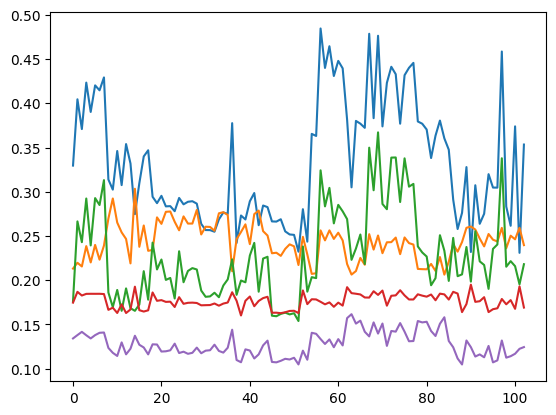

In [23]:
for i in range(n_experts):
    plt.plot(preds_phs["w"].mean(0)[i,:])

# BHS

In [24]:
def bhs(X, mu_preds, std_preds, y_val=None):
    N, M = mu_preds.shape

    assert mu_preds.shape == std_preds.shape

    ######################
    # GP for log weights #
    ######################
    with numpyro.plate("M", M):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_length = numpyro.sample(
            "kernel_length", dist.InverseGamma(5.0, 5.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))

    k = numpyro.deterministic(
        "k", vmap_SE_kernel(X, X, kernel_var, kernel_length, kernel_noise)
    )

    with numpyro.plate("logw_plate", M, dim=-1):
        w_un = numpyro.sample(
            "w_un", dist.MultivariateNormal(
                loc=-jnp.log(M), covariance_matrix=k)
        )

    log_w = jax.nn.log_softmax(w_un.T, axis=1)

    #################
    # Fuse with BHS #
    #################
    y_val_rep = jnp.tile(jnp.reshape(y_val, (-1, 1)), M)
    lpd_point = jax.scipy.stats.norm.logpdf(
        y_val_rep, loc=mu_preds, scale=std_preds)
    logp = jax.nn.logsumexp(lpd_point + log_w, axis=1)
    numpyro.deterministic("lpd_point", logp)
    numpyro.deterministic("w", jnp.exp(log_w))
    numpyro.factor("logp", jnp.sum(logp))


In [25]:
samples_bhs = train_stacking(model=bhs)
preds_bhs, lpd_bhs_test = predict_stacking(bhs,samples=samples_bhs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.33      0.78      1.11      0.38      2.35    173.48      1.02
kernel_length[1]      1.23      0.81      1.05      0.33      2.06    290.71      1.01
kernel_length[2]      1.19      0.74      0.99      0.39      2.03    299.10      1.00
kernel_length[3]      1.25      0.66      1.13      0.37      2.13    149.20      1.01
kernel_length[4]      1.33      0.75      1.16      0.52      2.26    117.96      1.04
 kernel_noise[0]      0.77      0.54      0.65      0.05      1.57     25.32      1.12
 kernel_noise[1]      1.02      0.69      0.99      0.02      1.83     20.62      1.27
 kernel_noise[2]      0.91      0.54      0.86      0.04      1.60     11.20      1.26
 kernel_noise[3]      0.82      0.59      0.69      0.02      1.60     40.30      1.10
 kernel_noise[4]      0.62      0.55      0.51      0.02      1.37     23.11      1.16
   kernel_var[0]      0.80      0.64      

In [26]:
-lpd_bhs_test.mean()

Array(0.3993651, dtype=float64)

In [27]:
preds_bhs["w"].shape

(400, 103, 5)

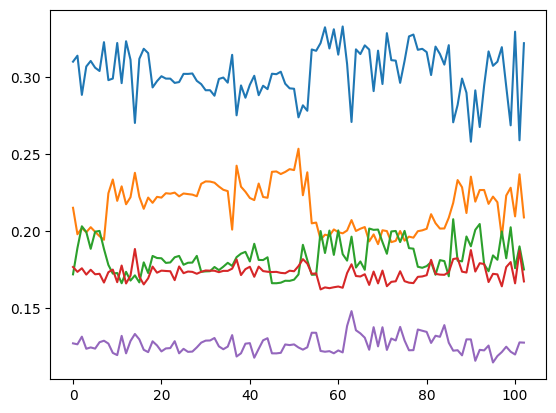

In [28]:
for i in range(n_experts):
    plt.plot(preds_bhs["w"].mean(0)[:,i])

# Variational inference

## First, MAP (Autodelta)

### PHS

100%|██████████| 5000/5000 [00:04<00:00, 1151.19it/s, init loss: 264.2785, avg. loss [4751-5000]: -1413.6639]


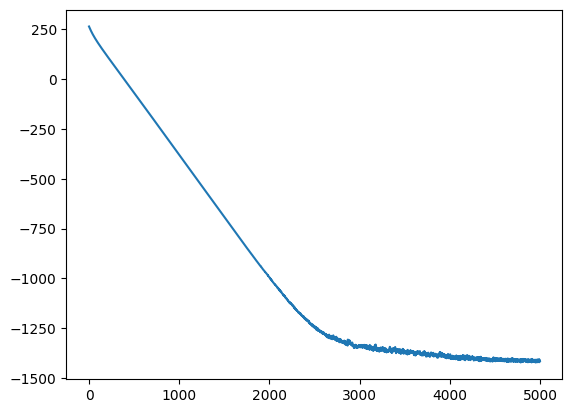

In [59]:
svi= SVI(mult_stack_gp_w_model
        ,
        AutoDelta(mult_stack_gp_w_model, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median
                  # init_loc_fn = numpyro.infer.initialization.init_to_uniform),
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.005)),
        # optim=numpyro.optim.
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )


res_phs = svi.run(
    random.PRNGKey(0),
    # 20,
    5000,  # for adam
    X_val,   
    mu_preds_val, 
    std_preds_val, 
    y_val=y_val,
)
plt.plot(res_phs[2])

In [60]:
params = res_phs.params
guide = AutoDelta(mult_stack_gp_w_model)
# use guide to make predictive
svi_predictive = Predictive(model=mult_stack_gp_w_model, 
                                       guide=guide, params=params, num_samples=1) # Since we are using the MAP, setting num_samples greater than 1 is pointless.
'''
below are predictions using the MAP estimates of all the parameters (it's only useful when predicting 
at the same x-values that were used for training the model; otherwise, it'll throw an error)
'''
point_estimates_at_val = svi_predictive(random.PRNGKey(0), 
                                                        X_val,   
                                                        mu_preds_val, 
                                                        std_preds_val, 
                                                        y_val=y_val,
                                                        )

In [61]:
point_estimates_at_val.keys()

dict_keys(['k', 'lpd_point', 'mean_fused', 'std_fused', 'tau_fused', 'w', 'y_val'])

In [62]:
-point_estimates_at_val["lpd_point"].mean(1)

Array([0.29672622], dtype=float64)

In [63]:
'''
we can compare the above lpd value with the one from MCMC (both on validation data)
'''
-np.mean(
    jax.nn.logsumexp(samples_phs["lpd_point"],axis=0) - np.log(samples_phs["lpd_point"].shape[0])
)

Array(0.07566959, dtype=float64)

In [64]:
# here we create a sample dictionary with the correct names
# we need to include a dim of legnth 1 at the beginning for being able to use the predict_stacking
samples_phs_svi = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    samples_phs_svi[f"{new_key}"] = value
    samples_phs_svi[f"{new_key}"] = samples_phs_svi[f"{new_key}"][np.newaxis]
    # print(new_key)
    # print(value)


In [65]:
samples_phs.keys()

dict_keys(['k', 'kernel_length', 'kernel_noise', 'kernel_var', 'lpd_point', 'mean_fused', 'std_fused', 'tau_fused', 'w', 'w_un'])

In [66]:
samples_phs_svi.keys() # these are the only params we care about for when using predict_stacking

dict_keys(['kernel_length', 'kernel_noise', 'kernel_var', 'w_un'])

In [72]:
samples_phs_svi["kernel_length"][0]

Array([0.8339163 , 0.83360708, 0.83533631, 0.83095957, 0.83443255],      dtype=float64)

In [73]:
# forma alternativa para obtener muestras (aunque todas seran iguales porque estamos usando el MAP)
guide = AutoDelta(mult_stack_gp_w_model)
predictive = Predictive(guide, params=params, num_samples=2)
posterior_samples = predictive(random.PRNGKey(1),X_val,mu_preds_val,std_preds_val,y_val)

In [74]:
posterior_samples["kernel_length"]

Array([[0.8339163 , 0.83360708, 0.83533631, 0.83095957, 0.83443255],
       [0.8339163 , 0.83360708, 0.83533631, 0.83095957, 0.83443255]],      dtype=float64)

In [37]:
preds_phs_svi, lpd_phs_test_svi = predict_stacking(
                                           model = mult_stack_gp_w_model,
                                           samples=samples_phs_svi,
                                           prior_mean=lambda x: -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]),
                                           )

In [38]:
print("NLPD MCMC", -lpd_phs_test.mean(0))
print("NLPD map", -lpd_phs_test_svi.mean(0))

NLPD MCMC 0.40396377562143965
NLPD map 0.43725171659540657


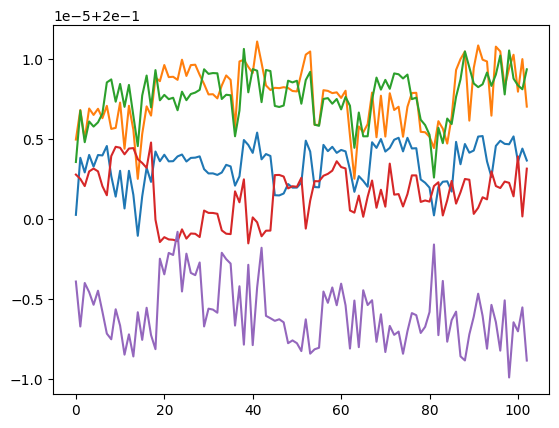

In [39]:
for i in range(n_experts):
    plt.plot(preds_phs_svi["w"].mean(0)[i,:])

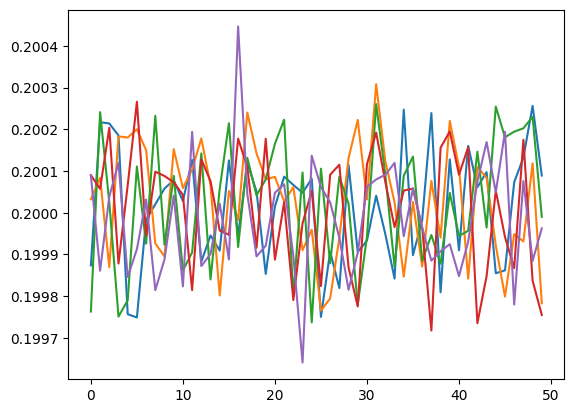

In [40]:
for i in range(n_experts):
    plt.plot(point_estimates_at_val["w"].mean(0)[i,:])

In [41]:
preds_phs_svi["w"][0]

Array([[0.20000025, 0.20000381, 0.2000029 , 0.20000399, 0.20000326,
        0.20000399, 0.20000396, 0.20000455, 0.20000267, 0.20000139,
        0.200003  , 0.20000065, 0.200003  , 0.2000015 , 0.19999895,
        0.20000141, 0.20000319, 0.20000231, 0.20000421, 0.2000036 ,
        0.200004  , 0.20000359, 0.2000036 , 0.2000039 , 0.20000402,
        0.20000358, 0.20000381, 0.20000382, 0.2000039 , 0.20000311,
        0.20000284, 0.20000284, 0.20000275, 0.2000029 , 0.20000338,
        0.20000328, 0.20000208, 0.20000266, 0.20000492, 0.20000462,
        0.20000412, 0.20000539, 0.20000372, 0.20000405, 0.20000393,
        0.20000148, 0.20000147, 0.20000159, 0.20000218, 0.20000195,
        0.20000196, 0.20000226, 0.20000488, 0.20000421, 0.20000199,
        0.20000197, 0.20000462, 0.20000423, 0.2000045 , 0.20000412,
        0.20000431, 0.20000421, 0.20000307, 0.20000169, 0.20000267,
        0.20000237, 0.20000201, 0.20000478, 0.20000443, 0.20000498,
        0.2000042 , 0.20000443, 0.20000494, 0.20

### BHS

100%|██████████| 3000/3000 [00:02<00:00, 1095.38it/s, init loss: 261.6124, avg. loss [2851-3000]: -1336.1661]


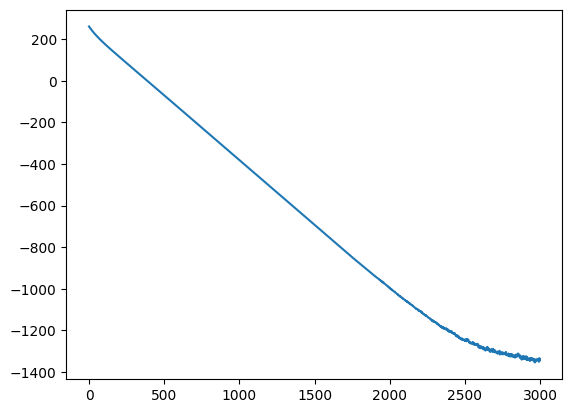

In [42]:
svi= SVI(bhs
        ,
        AutoDelta(bhs, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median
                  # init_loc_fn = numpyro.infer.initialization.init_to_uniform),
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.005)),
        # optim=numpyro.optim.
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )


res_bhs = svi.run(
    random.PRNGKey(0),
    # 20,
    3000,  # for adam
    X_val,   
    mu_preds_val, 
    std_preds_val, 
    y_val=y_val,
)
plt.plot(res_bhs[2])

In [43]:
params = res_bhs.params
guide = AutoDelta(bhs)
# use guide to make predictive
svi_predictive = Predictive(model=bhs,guide=guide, params=params, num_samples=1) # Since we are using the MAP, setting num_samples greater than 1 is pointless.
'''
below are predictions using the MAP estimates of all the parameters (it's only useful when predicting 
at the same x-values that were used for training the model; otherwise, it'll throw an error)
'''
point_estimates_at_val = svi_predictive(random.PRNGKey(0), 
                                                        X_val,   
                                                        mu_preds_val, 
                                                        std_preds_val, 
                                                        y_val=y_val,
                                                        )
print(-point_estimates_at_val["lpd_point"].mean(1))
'''
we can compare the above lpd value with the one from MCMC (both on validation data)
'''
print(
    -np.mean(
    jax.nn.logsumexp(samples_bhs["lpd_point"],axis=0) - np.log(samples_bhs["lpd_point"].shape[0])
)
)

[0.27739929]
0.22234033839684592


In [44]:
# here we create a sample dictionary with the correct names
# we need to include a dim of legnth 1 at the beginning for being able to use the predict_stacking
samples_bhs_svi = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    samples_bhs_svi[f"{new_key}"] = value
    samples_bhs_svi[f"{new_key}"] = samples_bhs_svi[f"{new_key}"][np.newaxis]
    # print(new_key)
    # print(value)
preds_bhs_svi, lpd_bhs_test_svi = predict_stacking(
                                           model = bhs,
                                           samples=samples_bhs_svi,
                                        #    prior_mean=lambda x: -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]),
                                           )
print("NLPD MCMC", -lpd_bhs_test.mean(0))
print("NLPD map", -lpd_bhs_test_svi.mean(0))

NLPD MCMC 0.39936510224478217
NLPD map 0.40110631695557125


In [45]:
preds_bhs_svi["w"].shape

(1, 103, 5)

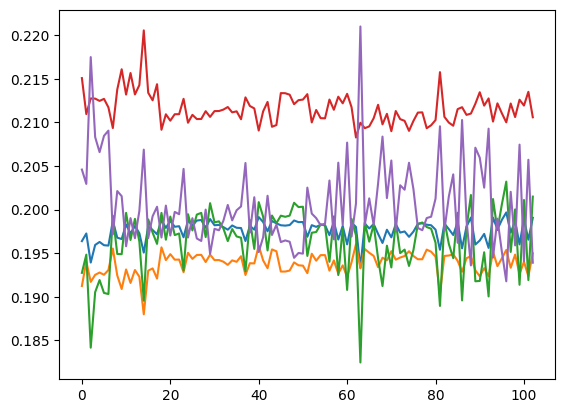

In [46]:
for i in range(n_experts):
    plt.plot(preds_bhs_svi["w"].mean(0).T[i,:])

## Second, Gaussian approx (AutoNormal)

### PHS

100%|██████████| 3000/3000 [00:03<00:00, 833.63it/s, init loss: 504.1798, avg. loss [2851-3000]: 38.5663] 


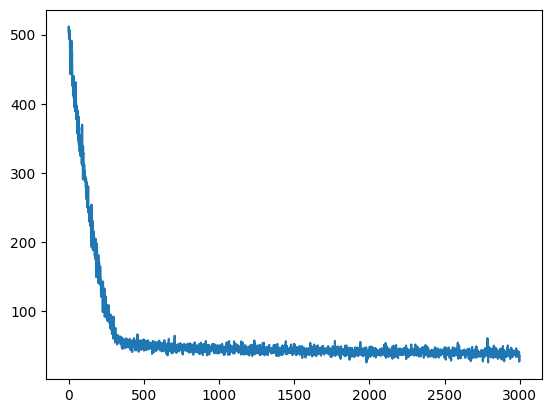

In [47]:
from numpyro.infer.autoguide import AutoNormal

svi= SVI(mult_stack_gp_w_model
        ,
        AutoNormal(mult_stack_gp_w_model, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median
                  # init_loc_fn = numpyro.infer.initialization.init_to_uniform),
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.005)),
        # optim=numpyro.optim.
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )


res_phs_normal = svi.run(
    random.PRNGKey(0),
    # 20,
    3000,  # for adam
    X_val,   
    mu_preds_val, 
    std_preds_val, 
    y_val=y_val,
)
plt.plot(res_phs_normal[2]);

In [48]:
params = res_phs_normal.params

Now we want to sample from this Gaussian approx to the posterior

In [49]:
guide = AutoNormal(mult_stack_gp_w_model)
predictive = Predictive(guide, params=params, num_samples=400)
posterior_samples = predictive(random.PRNGKey(1),X_val,mu_preds_val,std_preds_val,y_val)

In [50]:
posterior_samples["kernel_var"].shape

(400, 5)

In [51]:
# And we make predictions using these samples

preds_phs_normal, lpd_phs_test_normal = predict_stacking(
                                           model = mult_stack_gp_w_model,
                                           samples=posterior_samples,
                                           prior_mean=lambda x: -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]),
                                           )


In [52]:
print("NLPD MCMC", -lpd_phs_test.mean(0))
print("NLPD map", -lpd_phs_test_svi.mean(0))
print("NLPD GaussApprox", -lpd_phs_test_normal.mean(0))

NLPD MCMC 0.40396377562143965
NLPD map 0.43725171659540657
NLPD GaussApprox 0.43415792934535735


In [53]:
preds_phs_normal["w"].shape

(400, 5, 103)

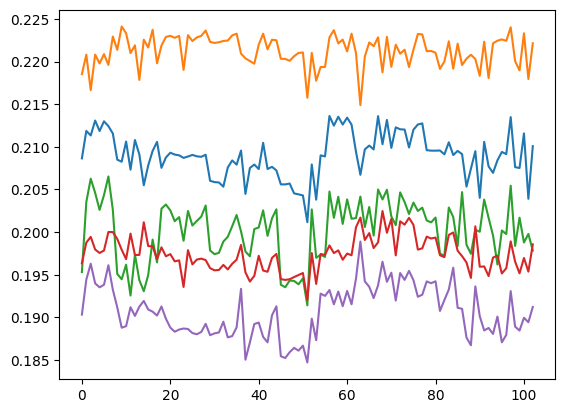

In [54]:
for i in range(n_experts):
    plt.plot(preds_phs_normal["w"].mean(0)[i,:])

### BHS

100%|██████████| 3000/3000 [00:03<00:00, 814.06it/s, init loss: 501.8341, avg. loss [2851-3000]: 38.1474] 


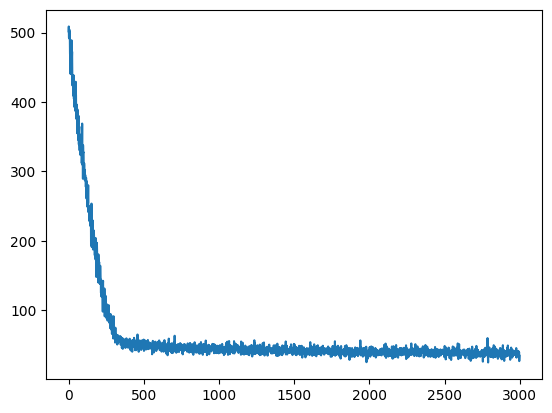

In [55]:
from numpyro.infer.autoguide import AutoNormal

svi= SVI(bhs
        ,
        AutoNormal(bhs, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median
                  # init_loc_fn = numpyro.infer.initialization.init_to_uniform),
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.005)),
        # optim=numpyro.optim.
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )


res_bhs_normal = svi.run(
    random.PRNGKey(0),
    # 20,
    3000,  # for adam
    X_val,   
    mu_preds_val, 
    std_preds_val, 
    y_val=y_val,
)
plt.plot(res_bhs_normal[2]);

In [56]:
guide = AutoNormal(bhs)
predictive = Predictive(guide, params=params, num_samples=400)
posterior_samples = predictive(random.PRNGKey(1),X_val,mu_preds_val,std_preds_val,y_val)

# And we make predictions using these samples

preds_bhs_normal, lpd_bhs_test_normal = predict_stacking(
                                           model = bhs,
                                           samples=posterior_samples,
                                        #    prior_mean=lambda x: -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]),
                                           )

In [57]:
print("NLPD MCMC", -lpd_bhs_test.mean(0))
print("NLPD map", -lpd_bhs_test_svi.mean(0))
print("NLPD GaussApprox", -lpd_bhs_test_normal.mean(0))

NLPD MCMC 0.39936510224478217
NLPD map 0.40110631695557125
NLPD GaussApprox 0.40054544127032593


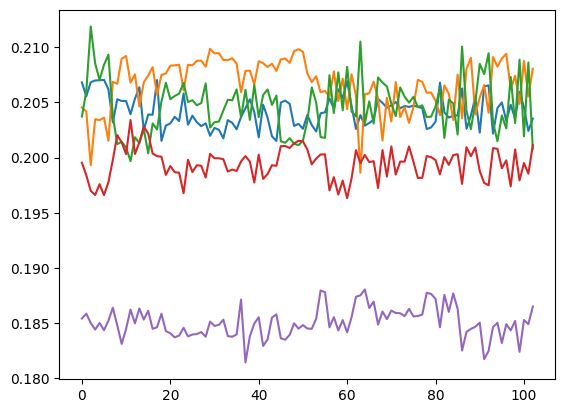

In [58]:
for i in range(n_experts):
    plt.plot(preds_bhs_normal["w"].mean(0).T[i,:])